# Tree ensemble example with TreeExplainer - XGBoost model

## Importing libraries



In [1]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

## Get the dataset

In [6]:
# Retrieve the dataset
X,y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult()

# X matrix dimension
X.shape

(32561, 12)

In [7]:
# Plot the head of X data
X.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


## Train the model

In [17]:
# use validation set to choose # of trees

model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


## Feature Importance Plot

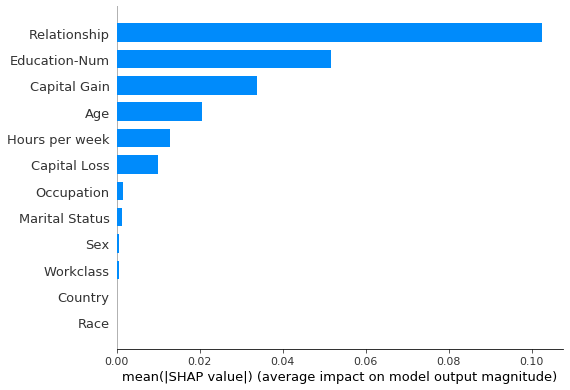

In [18]:

shap.summary_plot(shap_values, X, plot_type="bar")

## Summary Plot

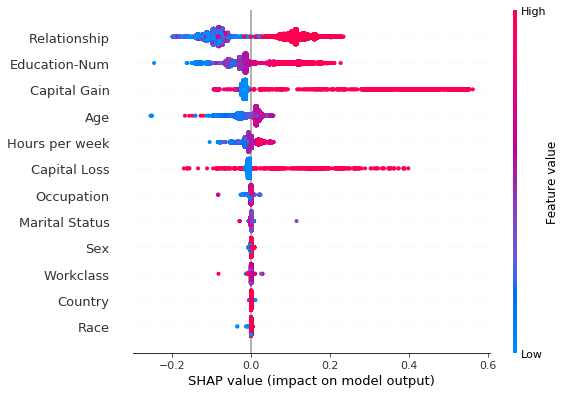

In [19]:
shap.summary_plot(shap_values, X)

## Force Plot


In [20]:

shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

With link function:

In [21]:

shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:], link='logit')

## Waterfall Plot
It's similar to Force Plot:

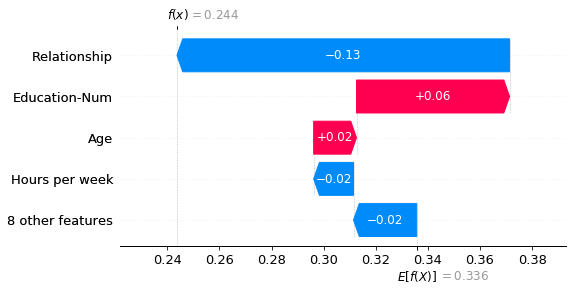

In [22]:

shap.waterfall_plot(explainer.expected_value, shap_values[0,:], feature_names=X.columns.values, max_display=5, show=True)

## Dependance Plot

+ Each dot is a single prediction (row) from the dataset.
+ The x-axis is the value of the feature (from the X matrix).
+ The y-axis is the SHAP value for that feature, which represents how much knowing that feature's value changes the output of the model for that sample's prediction.
+ The color corresponds to a second feature that may have an interaction effect with the feature we are plotting.

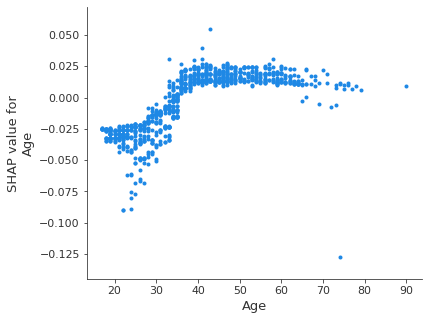

In [23]:
import numpy as np

np.random.seed(1)
sample_idx =  np.random.choice(len(X), size=1000, replace=False)

# Plot without interaction
shap.dependence_plot('Age', shap_values[sample_idx,:], X.iloc[sample_idx,:], interaction_index=None)

## Relationship:
+ "Not-in-family": 0,
+ "Unmarried": 1,
+ "Other-relative": 2,
+ "Own-child": 3,
+ "Husband": 4,
+ "Wife": 5

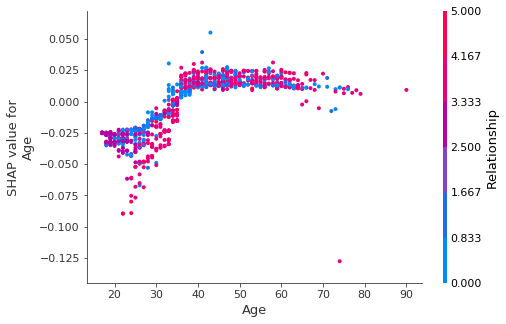

In [24]:
# Same plot with interaction
shap.dependence_plot('Age', shap_values[sample_idx,:], X.iloc[sample_idx,:], )

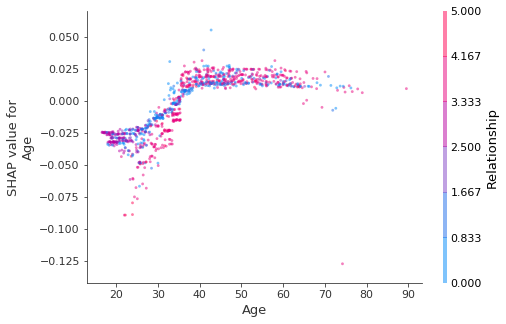

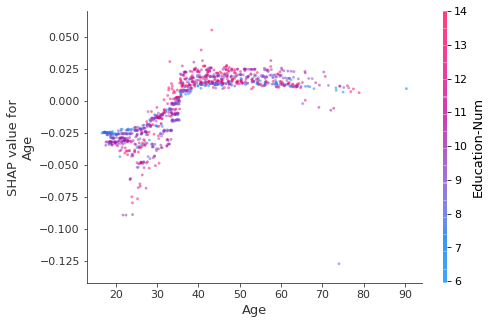

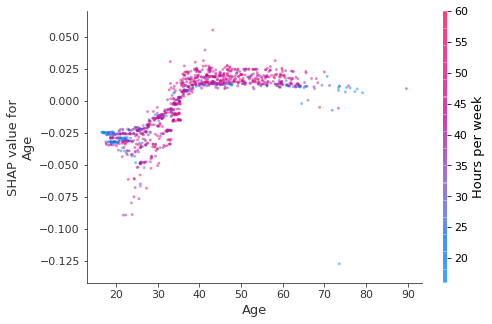

In [25]:
# Same plot with first 3 features(for importance) interaction

# We use shap.approximate_interactions to guess which features may interact with age.
inds = shap.approximate_interactions("Age", shap_values, X)

# Then:
for i in range(3):
    shap.dependence_plot("Age", shap_values[sample_idx,:], X.iloc[sample_idx,:], 
                         interaction_index=inds[i], alpha=0.5, x_jitter=1, dot_size=8)

## Cluster Plot

In [26]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[sample_idx,:], X.iloc[sample_idx,:])

## Compute SHAP Interaction Values
 Takes a couple minutes since SHAP interaction values take a factor of 2 * # features
 more time than SHAP values to compute
 since this is just an example we only explain
 the first 2,000 people in order to run quicker.

In [28]:
# Very slow, don't run
from sklearn.model_selection import train_test_split

X,y = shap.datasets.nhanesi()
X_display,y_display = shap.datasets.nhanesi(display=True) # human readable feature values

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)

# train final model on the full data set
model = xgboost.train(params, xgb_full, 5000, evals = [(xgb_full, "test")], verbose_eval=1000)



[0]	test-cox-nloglik:7.26934
[1000]	test-cox-nloglik:6.55589
[2000]	test-cox-nloglik:6.48688
[3000]	test-cox-nloglik:6.47248
[4000]	test-cox-nloglik:6.47038
[5000]	test-cox-nloglik:6.47187
[6000]	test-cox-nloglik:6.47413
[7000]	test-cox-nloglik:6.47631
[8000]	test-cox-nloglik:6.47931
[9000]	test-cox-nloglik:6.48236
[9999]	test-cox-nloglik:6.4856
[0]	test-cox-nloglik:8.88081
[1000]	test-cox-nloglik:8.16728
[2000]	test-cox-nloglik:8.07806
[3000]	test-cox-nloglik:8.03905
[4000]	test-cox-nloglik:8.01412
[4999]	test-cox-nloglik:7.99295


In [29]:
# Don't run
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X.iloc[:2000,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


## SHAP Interaction Value Summary Plot
A summary plot of a SHAP interaction value matrix plots a matrix of summary plots with the main effects on the diagonal and the interaction effects off the diagonal.

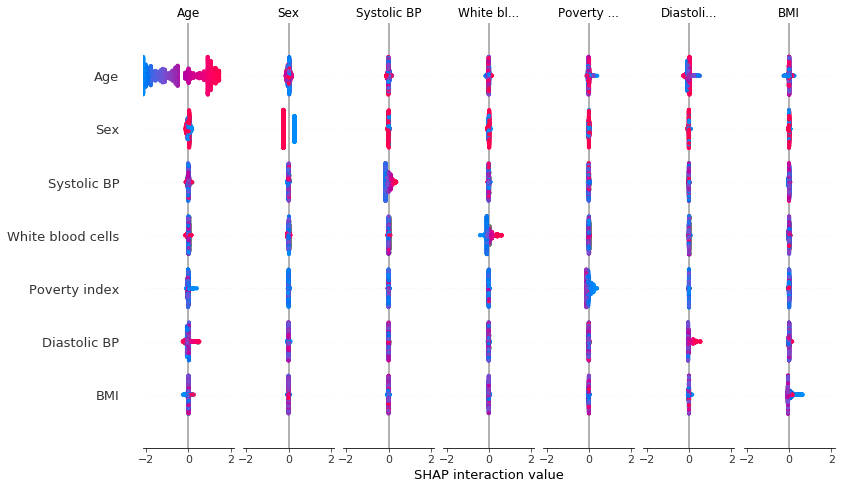

In [30]:
shap.summary_plot(shap_interaction_values, X.iloc[:2000,:])

Now we plot the interaction effects involving age. These effects capture all of the vertical dispersion that was present in the original SHAP plot but is missing from the main effects plot above. The plot below involving age and sex shows that the sex-based death risk gap varies by age and peaks at age 60.

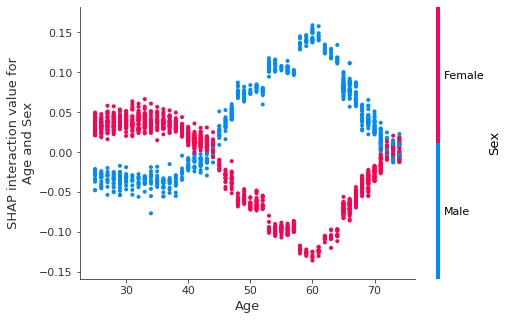

In [31]:
shap.dependence_plot(
    ("Age", "Sex"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

## Decision Plot features

Refer to the decision plot of the 20 test observations below. _Note: This plot isn't informative by itself; we use it only to illustrate the primary concepts._

+ The x-axis represents the model's output. In this case, the units are log odds.
+ The plot is centered on the x-axis at explainer.expected_value. All SHAP values are relative to the model's expected value like a linear model's effects are relative to the intercept.
+ The y-axis lists the model's features. By default, the features are ordered by descending importance. The importance is calculated over the observations plotted. _This is usually different than the importance ordering for the entire dataset._ In addition to feature importance ordering, the decision plot also supports hierarchical cluster feature ordering and user-defined feature ordering.
+ Each observation's prediction is represented by a colored line. At the top of the plot, each line strikes the x-axis at its corresponding observation's predicted value. This value determines the color of the line on a spectrum.
+ Moving from the bottom of the plot to the top, SHAP values for each feature are added to the model's base value. This shows how each feature contributes to the overall prediction.
+ At the bottom of the plot, the observations converge at explainer.expected_value.

## The new Model (with LightGBM)

In [32]:
from pprint import pprint
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pickle
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold
import warnings

X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)

# create a train/test split
random_state = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "random_state": random_state
}

model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)

explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = X_test.iloc[select]
features_display = X_display.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[683]	valid_0's binary_logloss: 0.277144
Explainer expected value: [-2.4296969]


The plot:

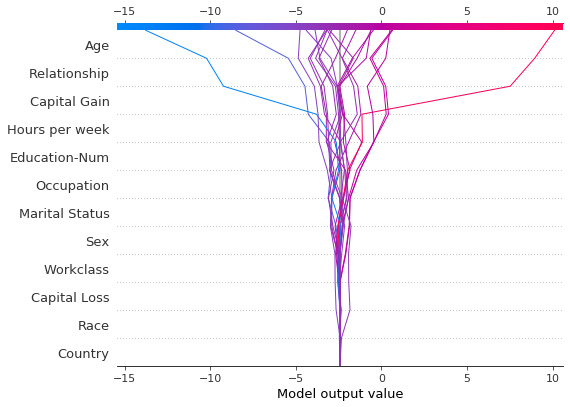

In [33]:

shap.decision_plot(expected_value, shap_values, features_display)

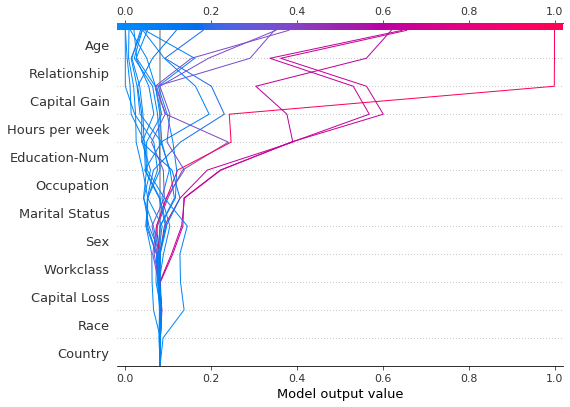

In [34]:
# Logit plot
shap.decision_plot(expected_value, shap_values, features_display, link='logit')

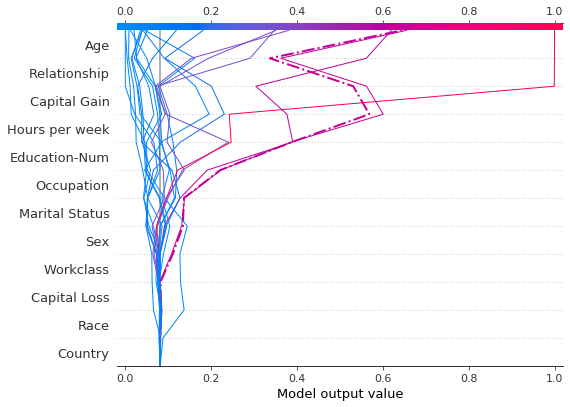

In [37]:
# Our naive cutoff point is zero log odds (probability 0.5).
y_pred = (shap_values.sum(1) + expected_value) > 0
misclassified = y_pred != y_test[select]
shap.decision_plot(expected_value, shap_values, features_display, link='logit', highlight=misclassified)

### Note

For non-linear functions ( like Random Forests, Gradient Boost, ...) the order in which features are introduced matters. SHAP values result from averaging over all possible orderings.

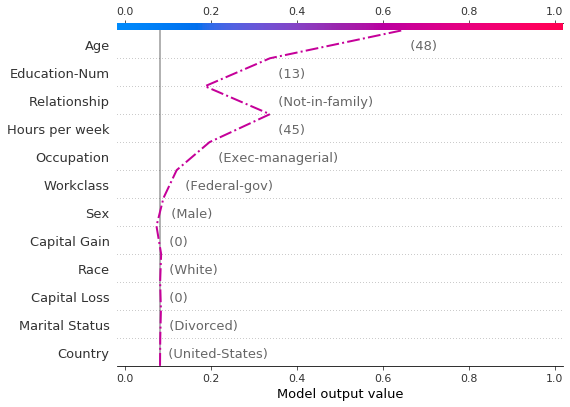

In [40]:
shap.decision_plot(expected_value, shap_values[misclassified], features_display[misclassified],
                   link='logit', highlight=0)

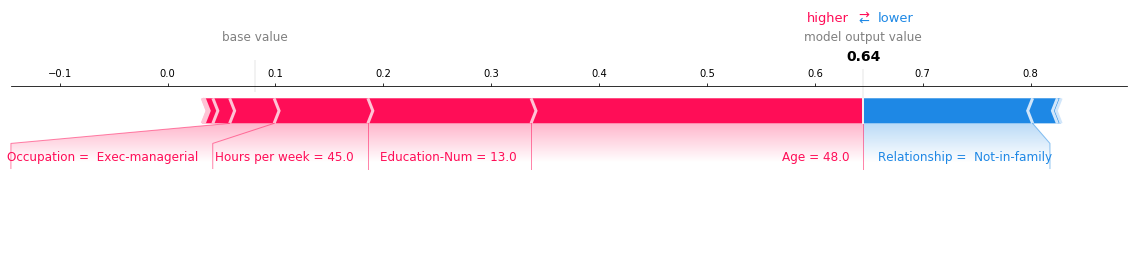

In [41]:
shap.force_plot(expected_value, shap_values[misclassified], features_display[misclassified], 
                link='logit', matplotlib=True)

## When is a decision plot helpful?
There are several use cases for a decision plot. We present several cases here.

1. Show a large number of feature effects clearly.
2. Visualize multioutput predictions.
3. Display the cumulative effect of interactions.
4. Explore feature effects for a range of feature values.
5. Identify outliers.
6. Identify typical prediction paths.
7. Compare and contrast predictions for several models.

In [42]:

# Create 'crime.pickle'

from sklearn.model_selection import train_test_split
import lightgbm as lgb
import pickle
import shap

random_state = 1203344

# Load data and train model
X, y = shap.datasets.communitiesandcrime()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)
model = lgb.LGBMRegressor(random_state=random_state)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Calculate and plot SHAP values
explainer = shap.TreeExplainer(model)
idx = 13
shap_values = explainer.shap_values(X_test.iloc[[idx]], y_test[idx])

# Dump to pickle
o = (explainer.expected_value, shap_values, X_test.iloc[0])
with open('./crime.pickle', 'wb') as fl:
    pickle.dump(o, fl)

# Load the prediction from disk to keep the example short.
with open(r'C:\Users\m.broglio\Documents\crime.pickle', 'rb') as fl:
    a, b, c = pickle.load(fl)

## Visualize multioutput predictions

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


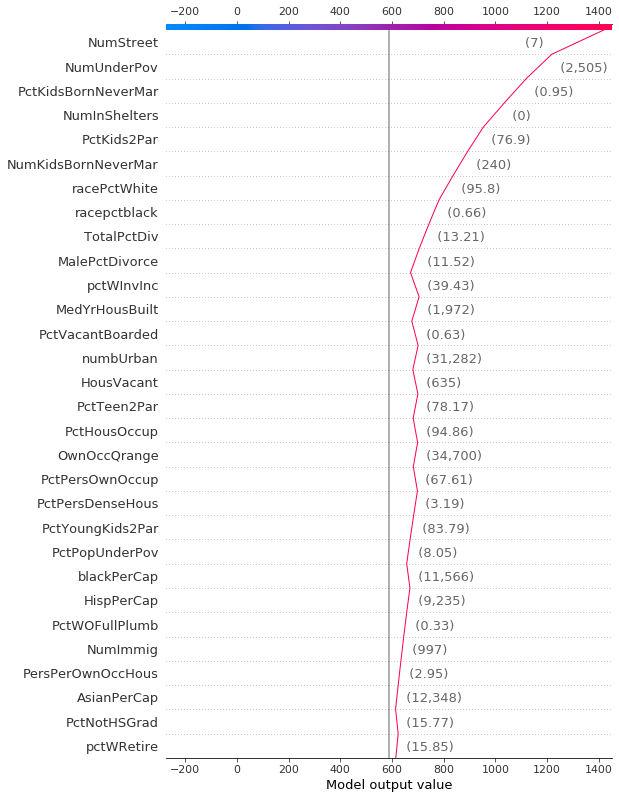

In [43]:
shap.decision_plot(a, b, c, feature_display_range=slice(None, -31, -1))

In [99]:
from sklearn import datasets
import xgboost as xgb
from sklearn.datasets import dump_svmlight_file
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

dump_svmlight_file(X_train, y_train, 'dtrain.svm', zero_based=True)
dump_svmlight_file(X_test, y_test, 'dtest.svm', zero_based=True)
dtrain_svm = xgb.DMatrix('dtrain.svm')
dtest_svm = xgb.DMatrix('dtest.svm')

param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations

model = xgb.train(param, dtrain, num_round)

#model.dump_model('dump.raw.txt')

explainer = shap.TreeExplainer(model)
#expected_value = explainer.expected_value


[00:17:47] 120x4 matrix with 480 entries loaded from dtrain.svm
[00:17:47] 30x4 matrix with 120 entries loaded from dtest.svm


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [100]:
iris_feature_names = iris.feature_names
iris_base_values = explainer.expected_value
iris_shap_values = explainer.shap_values(X_test)
iris_predictions = model.predict(dtest)
class_count = len(iris_base_values)

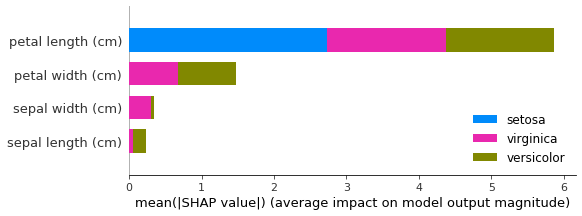

In [119]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test,approximate=False)
shap.summary_plot(shap_values, pd.DataFrame(X_test, columns=iris_feature_names ), 
                  plot_type="bar", class_names=iris.target_names)


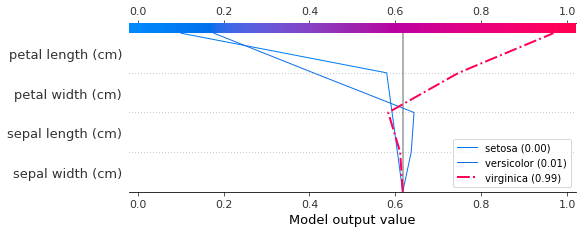

In [80]:
def class_labels(row_index):
    return [f'{iris.target_names[i]} ({iris_predictions[row_index, i].round(2):.2f})' for i in range(class_count)]

row_index=25
shap.multioutput_decision_plot(iris_base_values, 
                               iris_shap_values,
                               row_index = row_index,
                               feature_names=iris_feature_names, 
                               highlight=[np.argmax(iris_predictions[row_index])],
                               legend_labels=class_labels(row_index),
                               legend_location='lower right',
                               link='logit')  